# Deep Anomaly Detection

Обзор методов глубокого обучения для детектирования аномалий: https://habr.com/ru/post/530574/

Ноутбук взят отсюда: https://github.com/evjeny/ood_detection_autoencoders

В этом ноутбуке аномалии детектируются при помощи автокодировщиков.

# prepare data

In [1]:
import os

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [2]:
def gen_normal_distribution(mu, sigma, size, range=(0, 1), max_val=1):
  bins = np.linspace(*range, size)
  result = 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-(bins - mu)**2 / (2*sigma**2))

  cur_max_val = result.max()
  k = max_val / cur_max_val

  result *= k

  return result

In [3]:
dist = gen_normal_distribution(0.3, 0.05, 256, max_val=1)

In [4]:
dist.max()

1.0

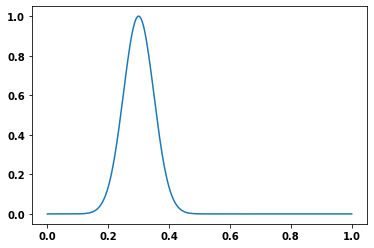

In [5]:
plt.plot(np.linspace(0, 1, 256), dist)

In [6]:
in_distribution_size = 2000
out_distribution_size = 200
val_size = 100
sample_size = 256

random_generator = np.random.RandomState(seed=42)

In [7]:
def generate_in_samples(size, sample_size):
  global random_generator

  in_samples = np.zeros((size, sample_size))

  in_mus = random_generator.uniform(0.1, 0.9, size)
  in_sigmas = random_generator.uniform(0.05, 0.5, size)

  for i in range(size):
    in_samples[i] = gen_normal_distribution(in_mus[i], in_sigmas[i], sample_size, max_val=1)
  
  return in_samples


def generate_out_samples(size, sample_size):
  global random_generator

  out_samples = generate_in_samples(size, sample_size)

  out_additional_mus = random_generator.uniform(0.1, 0.9, size)
  out_additional_sigmas = random_generator.uniform(0.01, 0.05, size)

  for i in range(size):
    anomaly = gen_normal_distribution(out_additional_mus[i], out_additional_sigmas[i], sample_size, max_val=0.12)
    out_samples[i] += anomaly
  
  return out_samples

In [8]:
in_samples = generate_in_samples(in_distribution_size, sample_size)

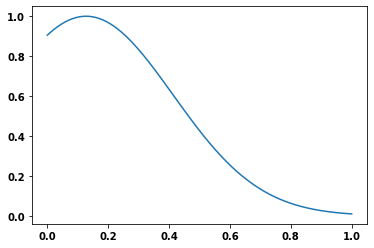

In [9]:
plt.plot(np.linspace(0, 1, sample_size), in_samples[42])

In [10]:
out_samples = generate_out_samples(out_distribution_size, sample_size)

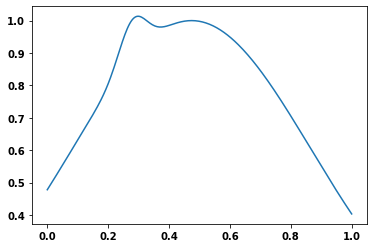

In [11]:
plt.plot(np.linspace(0, 1, sample_size), out_samples[42])

In [12]:
x = np.concatenate((in_samples, out_samples))
y = np.concatenate((np.zeros(in_distribution_size), np.ones(out_distribution_size)))

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    shuffle=True, random_state=42)

In [14]:
x_val_out = generate_out_samples(val_size, sample_size)
x_val_in = generate_in_samples(val_size, sample_size)
x_val = np.concatenate((x_val_out, x_val_in))
y_val = np.concatenate((np.ones(val_size), np.zeros(val_size)))

# models

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

## one-class svm

In [16]:
from sklearn.svm import OneClassSVM

In [17]:
out_dist_part = out_distribution_size / (out_distribution_size + in_distribution_size)
svm = OneClassSVM(nu=out_dist_part)

In [18]:
svm.fit(x_train, y_train)

OneClassSVM(nu=0.09090909090909091)

In [19]:
svm_prediction = svm.predict(x_val)
svm_prediction[svm_prediction == 1] = 0
svm_prediction[svm_prediction == -1] = 1

In [20]:
print(classification_report(y_val, svm_prediction))

              precision    recall  f1-score   support

         0.0       0.57      0.93      0.70       100
         1.0       0.81      0.29      0.43       100

    accuracy                           0.61       200
   macro avg       0.69      0.61      0.57       200
weighted avg       0.69      0.61      0.57       200



In [21]:
def svc_score(model, x, y):
  prediction = model.predict(x)
  prediction[prediction == 1] = 0
  prediction[prediction == -1] = 1

  score = f1_score(y, prediction)
  return score

In [22]:
svm_parameters = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "tol": [1e-4],
    "nu": [out_dist_part],
    "shrinking": [True]
}
svc_clf = GridSearchCV(OneClassSVM(), svm_parameters, scoring=svc_score, n_jobs=-1)
svc_clf.fit(x_train, y_train)

GridSearchCV(estimator=OneClassSVM(), n_jobs=-1,
             param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'nu': [0.09090909090909091], 'shrinking': [True],
                         'tol': [0.0001]},
             scoring=<function svc_score at 0x00000237398B70D8>)

In [23]:
svc_clf.best_params_

{'kernel': 'rbf', 'nu': 0.09090909090909091, 'shrinking': True, 'tol': 0.0001}

In [24]:
best_svc = svc_clf.best_estimator_

svm_prediction = best_svc.predict(x_val)
svm_prediction[svm_prediction == 1] = 0
svm_prediction[svm_prediction == -1] = 1

print(classification_report(y_val, svm_prediction))

              precision    recall  f1-score   support

         0.0       0.57      0.93      0.70       100
         1.0       0.81      0.29      0.43       100

    accuracy                           0.61       200
   macro avg       0.69      0.61      0.57       200
weighted avg       0.69      0.61      0.57       200



## isolation forest

In [25]:
from sklearn.ensemble import IsolationForest

In [26]:
out_dist_part = out_distribution_size / (out_distribution_size + in_distribution_size)

In [27]:
iso_forest = IsolationForest(n_estimators=100, contamination=out_dist_part, max_features=100, n_jobs=-1)
iso_forest.fit(x_train)

IsolationForest(contamination=0.09090909090909091, max_features=100, n_jobs=-1)

In [28]:
iso_forest_prediction = iso_forest.predict(x_val)
iso_forest_prediction[iso_forest_prediction == 1] = 0
iso_forest_prediction[iso_forest_prediction == -1] = 1

print(classification_report(y_val, iso_forest_prediction))

              precision    recall  f1-score   support

         0.0       0.51      0.91      0.65       100
         1.0       0.57      0.12      0.20       100

    accuracy                           0.52       200
   macro avg       0.54      0.52      0.43       200
weighted avg       0.54      0.52      0.43       200



## random forest classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
random_forest = RandomForestClassifier(n_estimators=100, max_features=100, n_jobs=-1)
random_forest.fit(x_train, y_train)

RandomForestClassifier(max_features=100, n_jobs=-1)

In [31]:
random_forest_prediction = random_forest.predict(x_val)
print(classification_report(y_val, random_forest_prediction))

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       100
         1.0       1.00      0.25      0.40       100

    accuracy                           0.62       200
   macro avg       0.79      0.62      0.56       200
weighted avg       0.79      0.62      0.56       200



## reconstruction models

In [33]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

In [ ]:
batch_size = 32
lr = 1e-3

In [ ]:
train_in_distribution = x_train[y_train == 0]
train_in_distribution = torch.tensor(train_in_distribution.astype(np.float32))

train_in_dataset = TensorDataset(train_in_distribution)
train_in_loader = DataLoader(train_in_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(
    torch.tensor(x_test.astype(np.float32)),
    torch.tensor(y_test.astype(np.long))
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(torch.tensor(x_val.astype(np.float32)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self, input_size):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Linear(input_size, 128),
      nn.LeakyReLU(0.2),
      nn.Linear(128, 64),
      nn.LeakyReLU(0.2),
      nn.Linear(64, 16),
      nn.LeakyReLU(0.2),
      nn.Linear(16, 4),
      nn.LeakyReLU(0.2),
    )
    self.decoder = nn.Sequential(
      nn.Linear(4, 16),
      nn.LeakyReLU(0.2),
      nn.Linear(16, 64),
      nn.LeakyReLU(0.2),
      nn.Linear(64, 128),
      nn.LeakyReLU(0.2),
      nn.Linear(128, 256),
      nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [ ]:
model = Autoencoder(sample_size).cuda()
criterion = nn.MSELoss()
per_sample_criterion = nn.MSELoss(reduction="none")
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

In [ ]:
def save_score_distribution(model, data_loader, criterion, save_to, figsize=(8, 6)):
  losses = []
  labels = []
  for (x_batch, y_batch) in data_loader:
    x_batch = x_batch.cuda()
    
    output = model(x_batch)
    loss = criterion(output, x_batch)
    
    loss = torch.mean(loss, dim=1)
    loss = loss.detach().cpu().numpy().flatten()
    losses.append(loss)
    
    labels.append(y_batch.detach().cpu().numpy().flatten())
  
  losses = np.concatenate(losses)
  labels = np.concatenate(labels)
  
  losses_0 = losses[labels == 0]
  losses_1 = losses[labels == 1]

  fig, ax = plt.subplots(1, figsize=figsize)

  ax.boxplot([losses_0, losses_1])
  ax.set_xticklabels(['normal', 'anomaly'])

  plt.savefig(save_to)
  plt.close(fig)

In [ ]:
save_score_distribution(model, test_loader, per_sample_criterion, "1.jpg")

In [ ]:
experiment_path = "ood_detection"
!rm -rf $experiment_path
os.makedirs(experiment_path, exist_ok=True)

In [ ]:
epochs = 100

In [ ]:
for epoch in range(epochs):
  running_loss = 0
  for (x_batch, ) in train_in_loader:
    x_batch = x_batch.cuda()
    
    output = model(x_batch)
    loss = criterion(output, x_batch)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  
  print("epoch [{}/{}], train loss:{:.4f}".format(epoch+1, epochs, running_loss))
  
  plot_path = os.path.join(experiment_path, "{}.jpg".format(epoch+1))
  save_score_distribution(model, test_loader, per_sample_criterion, plot_path)

In [ ]:
def get_prediction(model, x):
  global batch_size

  dataset = TensorDataset(torch.tensor(x.astype(np.float32)))
  data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
  
  predictions = []
  for batch in data_loader:
    x_batch = batch[0].cuda()
    pred = model(x_batch)
    predictions.append(pred.detach().cpu().numpy())
  
  predictions = np.concatenate(predictions)
  return predictions

In [ ]:
def compare_data(xs, sample_num, data_range=(0, 1), labels=None):
  fig, axes = plt.subplots(len(xs))
  sample_size = len(xs[0][sample_num])
  
  for i in range(len(xs)):
    axes[i].plot(np.linspace(*data_range, sample_size), xs[i][sample_num])
  
  if labels:
    for i, label in enumerate(labels):
      axes[i].set_ylabel(label)

In [ ]:
x_test_pred = get_prediction(model, x_test)

In [ ]:
compare_data([x_test[y_test == 0], x_test_pred[y_test == 0]], 10, labels=["real", "encoded"])

In [ ]:
compare_data([x_test[y_test == 1], x_test_pred[y_test == 1]], 10, labels=["real", "encoded"])

### embeddings

In [ ]:
def get_embedding(model, data_loader):
  x_emb = []
  for batch in data_loader:
    x_batch = batch[0].cuda()

    encoded_batch = model.encoder(x_batch)
    encoded_batch = encoded_batch.detach().cpu().numpy()
    
    x_emb.append(encoded_batch)

  x_emb = np.concatenate(x_emb)
  return x_emb

In [ ]:
x_test_encoded = get_embedding(model, test_loader)

In [ ]:
x_test_encoded.shape

In [ ]:
plt.imshow(x_test_encoded[:20])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
embeddings_forest = RandomForestClassifier()
embeddings_forest.fit(x_test_encoded, y_test)

In [ ]:
val_embeddings = get_embedding(model, val_loader)

In [ ]:
plt.imshow(val_embeddings[:20])

In [ ]:
val_prediction = embeddings_forest.predict(val_embeddings)
print(val_prediction)

In [ ]:
print(classification_report(y_val, val_prediction))

### difference score

In [ ]:
def get_difference_score(model, x):
  global batch_size

  dataset = TensorDataset(torch.tensor(x.astype(np.float32)))
  data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  predictions = []
  for (x_batch, ) in data_loader:
    x_batch = x_batch.cuda()
    preds = model(x_batch)
    predictions.append(preds.detach().cpu().numpy())
  
  predictions = np.concatenate(predictions)

  return (x - predictions)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
test_score = get_difference_score(model, x_test)

In [ ]:
score_forest = RandomForestClassifier(max_features=100)
score_forest.fit(test_score, y_test)

In [ ]:
val_score = get_difference_score(model, x_val)
prediction = score_forest.predict(val_score)
print(classification_report(y_val, prediction))

In [ ]:
indices = np.arange(len(prediction))
wrong_indices = indices[(prediction == 0) & (y_val == 1)]

In [ ]:
x_val_pred = get_prediction(model, x_val)

In [ ]:
compare_data([x_val, x_val_pred], wrong_indices[0])

In [ ]:
plt.imshow(val_score[wrong_indices], norm=Normalize(0, 1, clip=True))

In [ ]:
plt.imshow(val_score[(prediction == 1) & (y_val == 1)], norm=Normalize(0, 1, clip=True))

In [ ]:
plt.imshow(val_score[(prediction == 0) & (y_val == 0)], norm=Normalize(0, 1, clip=True))

#### difference histograms

In [ ]:
print("test score: [{}; {}]".format(test_score.min(), test_score.max()))

In [ ]:
def score_to_histograms(scores, bins=10, data_range=(-0.3, 0.3)):
  result_histograms = np.zeros((len(scores), bins))

  for i in range(len(scores)):
    hist, bins = np.histogram(scores[i], bins=bins, range=data_range)
    result_histograms[i] = hist
  
  return result_histograms

In [ ]:
test_histogram = score_to_histograms(test_score, bins=10, data_range=(-0.3, 0.3))
val_histogram = score_to_histograms(val_score, bins=10, data_range=(-0.3, 0.3))

In [ ]:
plt.title("normal histogram")
plt.bar(np.linspace(-0.5, 0.5, 10), test_histogram[y_test == 0][0])

In [ ]:
plt.title("anomaly histogram")
plt.bar(np.linspace(-0.5, 0.5, 10), test_histogram[y_test == 1][0])

In [ ]:
histogram_forest = RandomForestClassifier(n_estimators=10)
histogram_forest.fit(test_histogram, y_test)

In [ ]:
val_prediction = histogram_forest.predict(val_histogram)
print(val_prediction)

In [ ]:
print(classification_report(y_val, val_prediction))